In [1]:
# Some neccessary Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
%load_ext tensorboard

In [2]:
# Load the IRIS Dataset
Bank_note = pd.read_csv('BankNote.csv')
Bank_note.head() 

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
Bank_note.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
Bank_note.describe() # Statistical summary of the iris dataset

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [5]:
# Check for missing value
Bank_note.isnull().sum()/len(Bank_note)*100

variance    0.0
skewness    0.0
curtosis    0.0
entropy     0.0
class       0.0
dtype: float64

As you can see the result , there are no missing values

# Vizualization of the data

Text(0.5, 1.0, 'Distribution of Class')

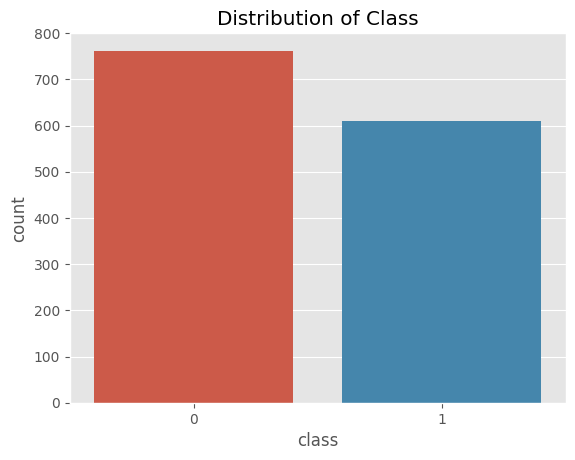

In [6]:
# Target Variable 
plt.style.use('ggplot')
sns.countplot(data = Bank_note , x = 'class')
plt.title('Distribution of Class')

### Data preprocessing Steps

In [7]:
# Split data into target & predictors
X = Bank_note.iloc[: , :4]
y = Bank_note.iloc[: , -1]

In [8]:
# Standard Scaling ,important for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Split the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=4)

n_features = X.shape[1]
n_classes = 2

In [10]:
# Convert the target labels to one-hot encoded format
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=2)

In [11]:
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=2)

In [12]:
# neural network architecture for adaptive activation function (AF) selection

initializer0 = keras.initializers.RandomUniform(minval = -0.01, maxval =0.1)
initializer1 = keras.initializers.RandomUniform(minval = -0.01, maxval =0.1)
initializer2 = keras.initializers.RandomUniform(minval = 0.5, maxval =1.5)

class Ada_act(keras.layers.Layer):
    def __init__(self):
        super(Ada_act, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

In [13]:
np.random.seed(1)

In [14]:
# Build model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(25, input_dim=n_features))
act = Ada_act()
model.add(act)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                125       
                                                                 
 ada_act (Ada_act)           (None, 25)                3         
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 52        
                                                                 
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


In [15]:
import datetime
batch_size = 5
epochs = 100

model.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics=["accuracy"])

log_dir = "irislogs/smallk1k0/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 ,callbacks=[tensorboard_callback], verbose=1)

Epoch 1/100
176/176 [==============================] - 4s 10ms/step - loss: 0.6566 - accuracy: 0.7138 - val_loss: 0.5465 - val_accuracy: 0.9227
Epoch 2/100
176/176 [==============================] - 1s 6ms/step - loss: 0.4311 - accuracy: 0.9236 - val_loss: 0.2969 - val_accuracy: 0.9318
Epoch 3/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2126 - accuracy: 0.9555 - val_loss: 0.1439 - val_accuracy: 0.9682
Epoch 4/100
176/176 [==============================] - 1s 6ms/step - loss: 0.1196 - accuracy: 0.9704 - val_loss: 0.0828 - val_accuracy: 0.9682
Epoch 5/100
176/176 [==============================] - 1s 6ms/step - loss: 0.0786 - accuracy: 0.9738 - val_loss: 0.0573 - val_accuracy: 0.9773
Epoch 6/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0588 - accuracy: 0.9749 - val_loss: 0.0430 - val_accuracy: 0.9773
Epoch 7/100
176/176 [==============================] - 1s 6ms/step - loss: 0.0420 - accuracy: 0.9840 - val_loss: 0.0330 - val_accuracy: 0.981

In [16]:
# parameter updates during training
parameter_updates = history.history['loss']
print(parameter_updates)

[0.6565720438957214, 0.4311194121837616, 0.2125508040189743, 0.11960410326719284, 0.0786048173904419, 0.05880362540483475, 0.042041655629873276, 0.03416147828102112, 0.028502168133854866, 0.021857280284166336, 0.020107708871364594, 0.020040476694703102, 0.013804201036691666, 0.014487273059785366, 0.011280222795903683, 0.008897453546524048, 0.00838122982531786, 0.007049514912068844, 0.007567534223198891, 0.007106890436261892, 0.004369424656033516, 0.0042212423868477345, 0.005721148569136858, 0.003901497693732381, 0.0035101238172501326, 0.005251436028629541, 0.00477660121396184, 0.0022918193135410547, 0.0021920064464211464, 0.0019013745477423072, 0.002721969271078706, 0.0024119908921420574, 0.0018051001243293285, 0.0012990087270736694, 0.0013277637772262096, 0.0012329668970778584, 0.001345100230537355, 0.0014024722622707486, 0.0008317796164192259, 0.001175801851786673, 0.0008166265906766057, 0.000888254726305604, 0.0003214396128896624, 0.0005563594168052077, 0.0009821692947298288, 0.0007

In [17]:
# final parameter values at the end of training
final_parameter_values = model.get_weights()
print(final_parameter_values)

[array([[-0.24071352, -0.6096078 ,  0.61637264,  0.7309875 ,  0.08967481,
        -0.22902389, -0.6228023 ,  0.09440634,  0.48228696, -0.4597672 ,
         0.00818666,  0.60549885, -0.47090602, -0.5393435 , -0.51918876,
        -0.38471827, -0.19228883,  0.44211498,  0.30615732,  0.09968814,
        -0.34719706, -0.6185756 , -0.3303811 ,  0.4310387 , -0.6459117 ],
       [-0.23980738, -0.53444415,  0.28188637, -0.17112583, -0.64380294,
        -0.3353822 , -0.63277686,  0.45381206,  0.33924896,  0.12291456,
         0.297356  ,  0.8671317 , -0.9050846 , -0.64934075, -0.46620223,
        -0.05640142, -0.4125823 , -0.08592622,  0.15538974, -0.03287636,
        -0.20782246, -0.24443798, -0.6983579 ,  0.6610683 , -0.08657779],
       [-0.00926459, -0.8016743 , -0.13505971,  0.3483953 , -0.06223223,
         0.00790286, -0.4599749 ,  0.85473627,  0.08995304, -0.2573706 ,
         0.10304641,  0.8172281 , -0.6581651 , -0.77171075, -0.94157064,
         0.41724023,  0.05238785, -0.7315285 ,  

In [18]:
total_parameters = model.count_params()
print(total_parameters)

180


In [19]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.00010452318383613601
Test accuracy: 1.0


In [20]:
# Optimal Value of k0,k1 & k2
print("AF coefficients (weights) {}".format(act.get_weights()))

AF coefficients (weights) [-1.1284701, 0.5461854, 2.984789]


In [21]:
from sklearn.metrics import f1_score
# training and test loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [22]:
print(train_loss[-1])

0.0001149530362454243


In [23]:
# training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [24]:
print(train_accuracy[-1])

1.0


In [25]:
# predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

9/9 [==============================] - 0s 3ms/step


In [26]:
#  F1-Score
f1 = f1_score(np.argmax(Y_test, axis=1), y_pred, average='weighted')

In [27]:
# Print test loss, test accuracy, and F1-Score
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("F1-Score:", f1)

Test loss: 0.00010452318383613601
Test accuracy: 1.0
F1-Score: 1.0


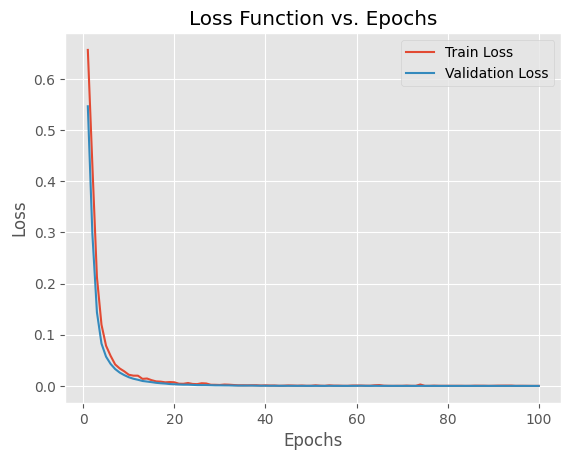

In [28]:
# Plot of loss function vs. epochs
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs')
plt.legend()
plt.show()